## Analysis of NYC Motor Vehicle Collisions
### IS 597 PRO Project

#### Team Members:
Adarsh Agarwal (adarsha2@illinois.edu, github - agarwaladarsh)

Sanhita Dhamdhere (sanhita2@illinois.edu, github - Sanhita207)

In [2]:
import pandas as pd
import numpy as np
import geojson
from datetime import datetime, time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# To remove pandas warnings - ref (https://stackoverflow.com/a/20627316)
pd.options.mode.chained_assignment = None  # default='warn'

Data Sources

- https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu
- https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
- https://worldpopulationreview.com/us-cities/new-york-city-ny-population
- https://www1.nyc.gov/assets/planning/download/office/planning-level/nyc-population/census2010/totpop_singage_sex2010_boro.xlsx
- https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90


References:

- _Stack Overflow_ :
    - https://stackoverflow.com/questions/50375985/pandas-add-column-with-value-based-on-condition-based-on-other-columns
    - https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    - https://stackoverflow.com/questions/44111307/python-pandas-count-rows-based-on-column
    - https://stackoverflow.com/questions/47502891/removing-group-header-after-pandas-aggregation
    - https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns

- _Others_ :
    - https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
    - https://datatofish.com/line-chart-python-matplotlib/
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    - https://github.com/rahulrohri/final_project_2020Sp
    - https://studio.mapbox.com/
    - https://plotly.com/python/scattermapbox/
    - https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90
    - https://plotly.com/python/mapbox-county-choropleth/
    - https://medium.com/@ingeh/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

In [4]:
NYC_collision_crashes_file = "Motor_Vehicle_Collisions_-_Crashes.csv"
NYC_collision_persons_file = "Motor_Vehicle_Collisions_-_Person.csv"
Population_by_age_2010 = 'population_by_age_2010.csv'
Zipcode_geojson = 'zipcode.geojson'

In [5]:
def load_collision_data(crashes_file, persons_file):
    """
    This function is used to load the 2 data frames of motor vehicle collisions - crashes and persons data.
    The files need to be present in the same directory as this current PY file,
        or the complete file path needs to be sent as the argument to this function.

    :param crashes_file: File name for the crashes dataset
    :param persons_file: File name for the persons dataset
    :return: crashes and persons dataframes


    >>> crashes, persons = load_collision_data('', '')
    Traceback (most recent call last):
    Exception: Please provide a valid file name
    """

    if not crashes_file or not persons_file:
        raise Exception('Please provide a valid file name')

    crashes = pd.read_csv(crashes_file, low_memory=False)
    persons = pd.read_csv(persons_file, low_memory=False)

    return crashes, persons

In [42]:
def get_nyc_population_data():
    """
    This function is used to fetch data about the population each year and calculated population density
        of NYC each year. This population density value will be used to normalize data for analysis.

    Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

    :return: dataframe containing the population and population density of NYC each year from 2012-2020
    >>> nyc_data = get_nyc_population_data()
    >>> nyc_data.iloc[0]['Population']
    8348030.0
    """

    nyc_population_data = {'Year': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
                           'Population': [8348030, 8398740, 8437390, 8468180, 8475980, 8438270, 8398750, 8361040, 8323340]
                           }

    nyc_population = pd.DataFrame(nyc_population_data, columns=['Year', 'Population'])

    nyc_area = 300.4  # (in sq miles) Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

    nyc_population.loc[:, 'Population_Density'] = nyc_population['Population'].apply(lambda x: x / nyc_area)

    return nyc_population

In [6]:
crashes, persons = load_collision_data(NYC_collision_crashes_file, NYC_collision_persons_file)

In [7]:
crashes.loc[:, 'CRASH_YEAR'] = crashes['CRASH DATE'].astype(np.str_).apply(lambda x: int(x.split('/')[-1]))

In [8]:
crashes.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'CRASH_YEAR'],
      dtype='object')

In [9]:
persons.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

## Hypothesis:
#### Of all collisions occurring late in the night (between 12 am - 5 am), the majority are caused due to an unsafe vehicle speed.

In [10]:
def get_night_crashes(crashes):
    """
    This function is used to perform a data transformation on the CRASH_TIME column present in the
        crashes dataframe provided as input. This transformed CRASH_TIME column will then be
        used to filter the crashes dataset and return all crashes data happening between 12 am to 5 am each day.

    :param crashes: Dataframe containing the crashes data for NYC Motor Vehicle Collisions
    :return: Crashes between 12 am to 5 am

    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> night_crash_data = get_night_crashes(crashes)
    >>> night_crash_data.shape[0]
    5
    """

    crashes['CRASH TIME'] = crashes['CRASH TIME'].apply(lambda x: datetime.strptime(x, "%H:%M").time())

    night_crash_data = crashes[(crashes['CRASH TIME'] < time(5, 0, 0))]

    return night_crash_data

In [11]:
def check_for_unsafe_speed(night_crash_data):
    """
    This function is used to scan the crashes data for columns containing the CONTRIBUTING FACTOR's
        for different vehicles and match it to the 'Unsafe Speed' value. If any vehicle's contributing
        factor is found to be 'Unsafe Speed', the collision is flagged in the 'hasUnsafeSpeed' column.

    :param night_crash_data: Data about all crashes happening between 12 am and 5 am
    :return: Updated crashes data with a flag column - 'hasUnsafeSpeed'

    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> crashes = check_for_unsafe_speed(crashes)
    >>> crashes['hasUnsafeSpeed'].value_counts().to_dict()
    {False: 9, True: 1}
    """

    night_crash_data = night_crash_data.assign(hasUnsafeSpeed=False)
    night_crash_data.loc[((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed') |
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'] == 'Unsafe Speed') |
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'] == 'Unsafe Speed') |
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'] == 'Unsafe Speed') |
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'] == 'Unsafe Speed')),
                         'hasUnsafeSpeed'] = True

    return night_crash_data

In [12]:
def calculate_percentage_of_speedy_collisions(night_crash_data):
    """
    This function is used to calculate the percentage of collisions which were flagged with having an
        unsafe speed as a contributing factor. This percentage value will provide a metric for the motor
        traffic department of NYC to identify if any stricter measures need to be taken

    :param night_crash_data: Data about all crashes happening between 12 am and 5 am
    :return: Float value signifying the percentage of collisions caused due to over speeding

    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> crashes = check_for_unsafe_speed(crashes)
    >>> calculate_percentage_of_speedy_collisions(crashes)['hasUnsafeSpeed']
    10.0
    """

    unsafe_speed_metrics = night_crash_data['hasUnsafeSpeed'].value_counts().to_frame()
    percentage_unsafe_speed_collisions = unsafe_speed_metrics.iloc[1] * 100 / night_crash_data.shape[0]

    return percentage_unsafe_speed_collisions

In [13]:
def calculate_invalid_collision_percentage(night_crash_data):
    """
    The columns in the crashes data set pertaining to the CONTRIBUTING FACTOR's either have missing
        values (NaN), or values such as '1', '80' and 'Unspecified'. This function is used to identify
        the rows with such values in the columns and return a percentage proportion to the complete dataset.

    :param night_crash_data: Data about all crashes happening between 12 am and 5 am
    :return: Float value signifying the percentage of collisions with an invalid/missing contributing factor

    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> calculate_invalid_collision_percentage(crashes)['isUnspecified']
    20.0
    """

    unwanted_contributing_factors = ['1', '80', 'Unspecified']

    night_crash_data.loc[:, 'isUnspecified'] = np.where(
        (((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isin(unwanted_contributing_factors)) |
          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isnull())) &
         ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isin(unwanted_contributing_factors)) |
          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isnull())) &
         ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isin(unwanted_contributing_factors)) |
          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull())) &
         ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isin(unwanted_contributing_factors)) |
          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull())) &
         ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isin(unwanted_contributing_factors)) |
          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull()))), True, False)

    invalid_night_crash_data_metrics = night_crash_data['isUnspecified'].value_counts().to_frame()

    percentage_invalid_collision_data = invalid_night_crash_data_metrics.iloc[1] * 100 / night_crash_data.shape[0]

    return percentage_invalid_collision_data

In [14]:
night_crash_data = get_night_crashes(crashes)

In [15]:
night_crash_data.head()

CRASH DATE CRASH TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
11  06/16/2018   00:05:00  MANHATTAN    10002  40.719970 -73.992905   
12  06/19/2018   01:00:00     QUEENS    11377  40.758960 -73.898384   
18  06/15/2018   00:52:00        NaN      NaN  40.780125 -73.953040   
25  06/04/2018   00:53:00   BROOKLYN    11238  40.673290 -73.957030   
54  06/26/2018   01:50:00     QUEENS    11101  40.748943 -73.954110   

                  LOCATION                    ON STREET NAME  \
11  (40.71997, -73.992905)  DELANCEY STREET                    
12  (40.75896, -73.898384)                               NaN   
18  (40.780125, -73.95304)  3 AVENUE                           
25   (40.67329, -73.95703)  STERLING PLACE                     
54  (40.748943, -73.95411)                               NaN   

   CROSS STREET NAME                           OFF STREET NAME  ...  \
11   CHRYSTIE STREET                                       NaN  ...   
12               NaN  30-46     69 STREET                       ...   
18               NaN                                       NaN  ...   
25   FRANKLIN AVENUE                                       NaN  ...   
54               NaN  5-26      45 AVENUE                       ...   

    CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
11                            NaN                            NaN   
12                            NaN                            NaN   
18                            NaN                            NaN   
25                            NaN                            NaN   
54                            NaN                            NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
11                            NaN       3922402   
12                            NaN       3926636   
18                            NaN       3924614   
25                            NaN       3915438   
54                            NaN       3929104   

                    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
11  Station Wagon/Sport Utility Vehicle  Station Wagon/Sport Utility Vehicle   
12                                Sedan                                Sedan   
18                                 Bike                                 Taxi   
25                                Sedan                                Sedan   
54                        Armored Truck                                Sedan   

    VEHICLE TYPE CODE 3  VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5 CRASH_YEAR  
11                  NaN                  NaN                 NaN       2018  
12                  NaN                  NaN                 NaN       2018  
18                  NaN                  NaN                 NaN       2018  
25                  NaN                  NaN                 NaN       2018  
54                  NaN                  NaN                 NaN       2018  

[5 rows x 30 columns]

In [16]:
night_crash_unsafe_speed_data = check_for_unsafe_speed(night_crash_data)

In [17]:
percentage_unsafe_speed_collisions = calculate_percentage_of_speedy_collisions(night_crash_unsafe_speed_data)
percentage_unsafe_speed_collisions

hasUnsafeSpeed    2.687928
Name: True, dtype: float64

In [18]:
percentage_invalid_collision_data = calculate_invalid_collision_percentage(night_crash_data)
percentage_invalid_collision_data

isUnspecified    34.79346
Name: True, dtype: float64

## Hypothesis:

#### More crashes are caused by the young inexperienced drivers (assuming 16-25 years of age) as compared to the more experienced drivers (assuming ages 26-99)

In [19]:
def get_merged_crashes_persons(crashes, persons):
    """
    Certain analyses require a dataframe containing data of both crashes and persons. This function
        is used to merge the crashes and persons dataframes, on the unique 'COLLISION_ID' column, drop
        duplicate 'CRASH_DATE', 'CRASH_TIME' and also the 'UNIQUE_ID' column which has no significance.

    :param crashes: Dataframe containing the crashes data for NYC Motor Vehicle Collisions
    :param persons: Dataframe containing the persons data for NYC Motor Vehicle Collisions
    :return: Merged dataframe containing the data of both crashes and persons. This will have more rows
        than the crashes dataframe.


    >>> crashes, persons = load_collision_data('doctest_dummy_files/crashes.csv', 'doctest_dummy_files/persons.csv')
    >>> crashes_persons = get_merged_crashes_persons(crashes, persons)
    >>> crashes_persons.iloc[0]['COLLISION_ID']
    3916262
    """

    crashes_persons = pd.merge(crashes, persons, left_on='COLLISION_ID', right_on='COLLISION_ID', how='inner')
    crashes_persons.loc[:, 'CRASH_YEAR'] = crashes_persons['CRASH_DATE'].astype(np.str_).apply(lambda x: x.split('/')[-1])
    del crashes_persons['CRASH_DATE']
    del crashes_persons['CRASH_TIME']
    del crashes_persons['UNIQUE_ID']
    return crashes_persons

In [1]:
def get_crashes_driver_age_groups(crashes_persons, columns):
    """
    This function is used to first filter the merged crashes_persons dataframe for rows involving only the
        driver. After that all rows where the age of the driver is between 16 - 25 years is flagged in the
        'age16-25' column and similarly all rows where age of the driver is between 26 - 99 years is flagged in the 'age26-99' column. 
        This is done to identify the proportion of collisions involving the two age groups.

    :param crashes_persons: Merged dataframe containing the data of both crashes and persons.
    :param columns: The list of columns to use
    :return: Grouped dataframe containing only the 'Driver' data


    >>> crashes, persons = load_collision_data('doctest_dummy_files/crashes.csv', 'doctest_dummy_files/persons.csv')
    >>> crashes_persons = get_merged_crashes_persons(crashes, persons)
    >>> crashes_driver_age_group = get_crashes_driver_age_groups(crashes_persons, ['CRASH_YEAR', 'PERSON_AGE'])
    >>> crashes_driver_age_group.iloc[0]['PERSON_AGE']
    16.0
    """

    crashes_driver_age_group = crashes_persons[crashes_persons['POSITION_IN_VEHICLE'] == 'Driver'][columns]
    crashes_driver_age_group.loc[:, 'age16-25'] = np.where((crashes_driver_age_group['PERSON_AGE'] > 15) &
                                                               (crashes_driver_age_group['PERSON_AGE'] < 26), True, False)
    crashes_driver_age_group.loc[:, 'age26-99'] = np.where((crashes_driver_age_group['PERSON_AGE'] > 25) &
                                                               (crashes_driver_age_group['PERSON_AGE'] < 100), True, False)
    return crashes_driver_age_group

In [99]:
def get_population_proportion_data(filename):
    """
    This function is used to fetch the population demographics by age for the year 2010. The 'proportion' field from this
        data will be used later on to normalize the crashes data for the 2 age groups - 16-25 years of age and 26-99
        years of age.
    :param filename: Filename / Complete path to the population demographics by age data for NYC (present in repo)
    :return: dataframe containing population proportion

    >>> pop_proportion = get_population_proportion_data('population_by_age_2010.csv')
    >>> pop_proportion.iloc[16]['population']
    102804
    """
    population_by_age_2010 = pd.read_csv(filename)
    population_by_age_2010.loc[:, 'proportion'] = population_by_age_2010['population'] / population_by_age_2010[
        'population'].sum()
    return population_by_age_2010

In [100]:
def get_norm_crashes_groupedby_year_age_group(crashes_driver_age_groups, pop_prop_16_25, pop_prop_26_99):
    """
    This function will be used to fetch a grouped dataframe containing normalized number of crashes for age groups
        16-25 years and 26-99 years. The normalization is done using the populations obtained from the
        NYC population demographics by age dataset and NYC population each year.
    :param crashes_persons_age_grouping: Merged crashes and persons dataframe
    :param pop_prop_16_25: population proportion factor for age group 16-25 years
    :param pop_prop_26_99: population proportion factor for age group 26-99 years
    :return: grouped dataframe containing normalized number of crashes by age groups
    """
    
    nyc_population = get_nyc_population_data()
    
    crashes_driver_age_groups = crashes_driver_age_groups.groupby(['CRASH_YEAR', 'PERSON_AGE']).size().reset_index()
    crashes_driver_age_groups = crashes_driver_age_groups.rename(columns={0: 'crashes'})
    crashes_driver_age_groups.loc[:, 'age_group'] = np.where((crashes_driver_age_groups['PERSON_AGE'] > 15) &
                                                       (crashes_driver_age_groups['PERSON_AGE'] < 26), '16-25', '26-99')

    crashes_driver_age_groups = crashes_driver_age_groups.groupby(['CRASH_YEAR', 'age_group']).agg({'crashes': ['sum']}).reset_index()
    crashes_driver_age_groups.columns = crashes_driver_age_groups.columns.droplevel(1)
    crashes_driver_age_groups = crashes_driver_age_groups.pivot(index='CRASH_YEAR', columns='age_group', values='crashes')
    
    crashes_driver_age_groups = crashes_driver_age_groups.reset_index()
    
    crashes_driver_age_groups['CRASH_YEAR'] = crashes_driver_age_groups['CRASH_YEAR'].astype('int64')
    
    merged_df = pd.merge(crashes_driver_age_groups, nyc_population, left_on='CRASH_YEAR', right_on='Year', how='inner')
    
    merged_df.loc[:, 'norm_16-25'] = (merged_df['16-25']*100000) / (merged_df['Population'] * pop_prop_16_25)
    merged_df.loc[:, 'norm_26-99'] = (merged_df['26-99']*100000) / (merged_df['Population'] * pop_prop_26_99)
    
    return merged_df

In [97]:
def plot_crashes_age_groups(crashes_by_year_age_grouped):
    """
    This function is used to plot a line chart of the normalized number of crashes per year for age groups 16-25 and 26-99 per 
    100,000 population.
    :param crashes_by_year_age_grouped: Grouped data containing normalized number of crashes for both age groups per 100,000 
    population
    """

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_16-25'].tolist(),
        name="Age group 16-25"
    ))

    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_26-99'].tolist(),
        name="Age group 26-99"
    ))

    fig.update_layout(
        title="Plot of normalized number of crashes per year for age groups 16-25 and 26-99 per 100,000 population",
        xaxis_title="Year",
        yaxis_title="Normalized number of crashes per 100,000 population",
        legend_title="Legend",
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    fig.show()


In [22]:
crashes_persons = get_merged_crashes_persons(crashes, persons)

In [23]:
crashes_persons['PERSON_TYPE'].unique()

array(['Occupant', 'Pedestrian', 'Bicyclist'], dtype=object)

In [25]:
# dropping all rows where there is no vehicle ID present
crashes_persons.drop(crashes_persons.loc[crashes_persons['VEHICLE_ID'].isna()].index, inplace=True)

In [69]:
columns = ['CRASH_YEAR', 'PERSON_AGE']
crashes_driver_age_groups = get_crashes_driver_age_groups(crashes_persons, columns)
crashes_driver_age_groups.head()

CRASH_YEAR  PERSON_AGE  age16-25  age26-99
1       2018        57.0     False      True
5       2018        38.0     False      True
6       2018        39.0     False      True
8       2018        43.0     False      True
9       2018        83.0     False      True

In [70]:
crashes_driver_age_groups.loc[:, 'ageBelow16'] = np.where(crashes_driver_age_groups['PERSON_AGE'] < 16, True, False)
crashes_driver_age_groups['ageBelow16'].value_counts()

False    1465016
True        8528
Name: ageBelow16, dtype: int64

In [71]:
crashes_driver_age_groups.loc[:, 'ageAbove99'] = np.where(crashes_driver_age_groups['PERSON_AGE'] > 99, True, False)
crashes_driver_age_groups['ageAbove99'].value_counts()

False    1472186
True        1358
Name: ageAbove99, dtype: int64

In [52]:
crashes_driver_age_groups['PERSON_AGE'].isna().sum()

5066

In [72]:
# Dropping all rows with age < 16, age > 99 and age Nan
crashes_driver_age_groups.drop(
    crashes_driver_age_groups.loc[(crashes_driver_age_groups['ageBelow16']) | 
                                  (crashes_driver_age_groups['ageAbove99']) | 
                                  (crashes_driver_age_groups['PERSON_AGE'].isna())].index, inplace=True)

Using the 2010 population by age demographics of NYC for getting the population proportions by age

In [34]:
pop_prop_by_age_2010 = get_population_proportion_data(Population_by_age_2010)

In [36]:
# Proportion of population for the age group 16-25
ages = [str(i) for i in range(16, 26)]
pop_prop_16_25 = pop_prop_by_age_2010[pop_prop_by_age_2010['age'].isin(ages)]['proportion'].sum()
pop_prop_16_25

0.15003046433617656

In [40]:
# Proportion of population for the age group 26-99
ages = [str(i) for i in range(26, 100)]
pop_prop_26_99 = pop_prop_by_age_2010[pop_prop_by_age_2010['age'].isin(ages)]['proportion'].sum()
pop_prop_26_99

0.6589243257571468

In [92]:
norm_crashes_driver_age_groups = get_norm_crashes_groupedby_year_age_group(crashes_driver_age_groups, pop_prop_16_25, pop_prop_26_99)
norm_crashes_driver_age_groups

CRASH_YEAR  16-25   26-99  Year  Population  Population_Density  \
0        2012     12      19  2012     8348030        27789.713715   
1        2013     11      50  2013     8398740        27958.521971   
2        2014     30     124  2014     8437390        28087.183755   
3        2015     45     174  2015     8468180        28189.680426   
4        2016  41268  245473  2016     8475980        28215.645806   
5        2017  50792  305532  2017     8438270        28090.113182   
6        2018  49200  308564  2018     8398750        27958.555260   
7        2019  44203  279581  2019     8361040        27833.022636   
8        2020  21468  112046  2020     8323340        27707.523302   

    norm_16-25   norm_26-99  
0     0.958115     0.345409  
1     0.872970     0.903484  
2     2.369920     2.230376  
3     3.541955     3.118341  
4  3245.219263  4395.196196  
5  4012.014032  5495.000606  
6  3904.550060  5575.644310  
7  3523.806001  5074.716811  
8  1719.152874  2042.975604

In [98]:
plot_crashes_age_groups(norm_crashes_driver_age_groups)

## Hypothesis

#### The number of collisions increase with an increase in population

Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

In [94]:
def get_total_crashes_per_year(crashes):
    """
    This function is used to fetch the total number of crashes occurring per year. The crashes data needs
        a data type conversion of the CRASH_YEAR column to 'int64' type.

    :param crashes: Dataframe containing the crashes data for NYC Motor Vehicle Collisions
    :return: Dataframe containing the total crashes occurred per year

    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> crashes.loc[:, 'CRASH_YEAR'] = crashes['CRASH DATE'].astype(np.str_).apply(lambda x: int(x.split('/')[-1]))
    >>> total_crashes_per_year = get_total_crashes_per_year(crashes)
    >>> total_crashes_per_year.iloc[0]['Total_Crashes']
    10
    """

    crashes_data = crashes.copy()
    crashes_total = crashes_data.groupby(['CRASH_YEAR'], sort=False).size().reset_index(name='Total_Crashes')
    crashes_total['CRASH_YEAR'] = crashes_total['CRASH_YEAR'].astype('int64')

    crashes_total = crashes_total.sort_values(by=['CRASH_YEAR'])

    return crashes_total

In [95]:
def calculate_crashes_per_capita(crashes_total, nyc_population):
    """
    This function is used to calculate the metric 'Crashes_per_capita' which is basically the number of
        crashes occurring per year per individual in the population. The total crashes occurring per year
        is divided by the population of that year.

    :param crashes_total: Dataframe containing the total crashes occurred per year
    :param nyc_population: Dataframe containing the NYC population per year
    :return: Merged dataframe containing total crashes data and population values and also the calculated
        metric 'Crashes_per_capita'


    >>> total_crashes = pd.read_csv('doctest_dummy_files/crashes_total.csv')
    >>> population = get_nyc_population_data()
    >>> crashes_population = calculate_crashes_per_capita(total_crashes, population)
    >>> round(crashes_population.iloc[0]['Crashes_per_capita'], 6)
    0.012044
    """

    crashes_population = pd.merge(crashes_total, nyc_population, left_on='CRASH_YEAR', right_on='Year', how='inner')

    crashes_population.loc[:, 'Crashes_per_capita'] = crashes_population['Total_Crashes'] / crashes_population['Population']

    return crashes_population

In [96]:
def plot_crashes_per_capita_vs_year(crashes_population):
    """
    This function is used to plot a line chart of the Crashes Per Capita over the years.

    :param crashes_population: Merged dataframe containing total crashes data and population values and also the calculated
        metric 'Crashes_per_capita'
    """

    plt.plot(crashes_population['Year'], crashes_population['Crashes_per_capita'], color='red', marker='o')
    plt.title('Crashes_per_Capita Vs Year for NYC')
    plt.xlabel('Year')
    plt.ylabel('Crashes_per_capita')
    plt.show()


In [124]:
def plot_population_density_vs_year(crashes_population):
    """
    This function is used to plot a line chart of the Pppulation Density over the years.

    :param crashes_population: Merged dataframe containing total crashes data and population values and also the calculated
        metric 'Crashes_per_capita'
    """

    plt.plot(crashes_population['Year'], crashes_population['Population_Density'], color='red', marker='o')
    plt.title('Population Density Vs Year for NYC')
    plt.xlabel('Year')
    plt.ylabel('Population Density')
    plt.show()


In [98]:
NYC_Population = get_NYC_population_data()
NYC_Population.head()

Year  Population  Population_Density
0  2012     8348030        27789.713715
1  2013     8398740        27958.521971
2  2014     8437390        28087.183755
3  2015     8468180        28189.680426
4  2016     8475980        28215.645806

In [102]:
crashes_total = get_total_crashes_per_year(crashes)
crashes_total

CRASH_YEAR  Total_Crashes
4        2012         100541
8        2013         203734
7        2014         206033
6        2015         217694
5        2016         229830
1        2017         231007
0        2018         231562
2        2019         211481
3        2020          99840

In [103]:
crashes_population = calculate_crashes_per_capita(crashes_total, NYC_Population)
crashes_population

CRASH_YEAR  Total_Crashes  Year  Population  Population_Density  \
0        2012         100541  2012     8348030        27789.713715   
1        2013         203734  2013     8398740        27958.521971   
2        2014         206033  2014     8437390        28087.183755   
3        2015         217694  2015     8468180        28189.680426   
4        2016         229830  2016     8475980        28215.645806   
5        2017         231007  2017     8438270        28090.113182   
6        2018         231562  2018     8398750        27958.555260   
7        2019         211481  2019     8361040        27833.022636   
8        2020          99840  2020     8323340        27707.523302   

   Crashes_per_capita  
0            0.012044  
1            0.024258  
2            0.024419  
3            0.025707  
4            0.027115  
5            0.027376  
6            0.027571  
7            0.025294  
8            0.011995

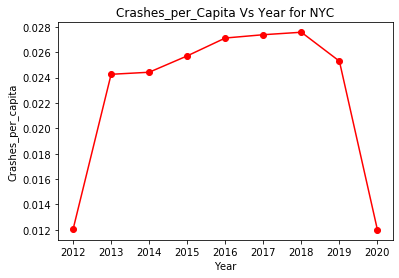

In [104]:
plot_crashes_per_capita_vs_year(crashes_population)

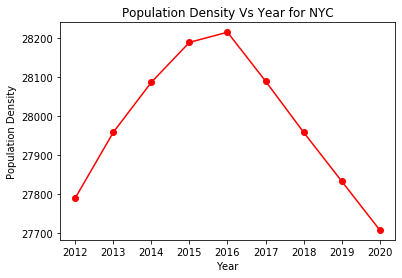

In [126]:
plot_population_density_vs_year(crashes_population)

In [106]:
crashes_population_subset = crashes_population.drop([0,8],0)

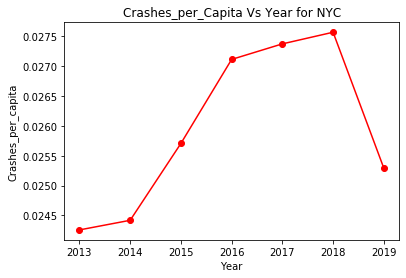

In [107]:
plot_crashes_per_capita_vs_year(crashes_population_subset)

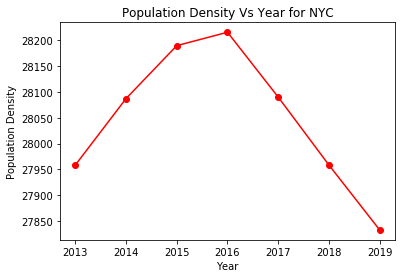

In [125]:
plot_population_density_vs_year(crashes_population_subset)

## Additional Observations

In [112]:
def set_up_crashes_for_map(crashes, geojson_filename, year=0):
    """
    This function is used to setup the dataframes required to plot a heat map of all crashes in NYC. A geojson file is
        used and an additional 'id' key is added to allow plotly to link the dataframe and geojson together for the plot.
    :param crashes: Dataframe containing the crashes data for NYC Motor Vehicle Collisions
    :param geojson_filename: Filename/complete path to the zipcode.geojson file (present in repo)
    :param year: Integer value for the year of collision
    :return: crashes_per_zipcode dataframe and geojson


    >>> crashes = pd.read_csv('doctest_dummy_files/crashes.csv')
    >>> crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, 'zipcode.geojson')
    >>> gj['features'][0]['id']
    '11372'
    """

    if year == 0:
        df = crashes
    else:
        df = crashes[crashes['CRASH_YEAR'] == year]
    with open(geojson_filename) as f:
        gj = geojson.load(f)
        for feature in gj['features']:
            zipcode = feature['properties']['postalCode']
            feature['id'] = zipcode
    crashes_per_zipcode = df.groupby(['ZIP CODE'], sort=True).size().reset_index(name='crashes_per_zipcode')
    crashes_per_zipcode = crashes_per_zipcode.rename(columns={'ZIP CODE': 'zipcode'})
    crashes_per_zipcode.drop(crashes_per_zipcode[(crashes_per_zipcode['zipcode'].isna()) |
                                                 (crashes_per_zipcode['zipcode'] == "     ")].index, inplace=True)
    return crashes_per_zipcode, gj


In [115]:
def plot_crash_locations(crashes_per_zipcode, gj):
    """
    This function is used to plot the heat map of crashes in NYC. This function uses the python-plotly
        library to plot a Chloropleth Map Box. A Mapbox access token is required, which can be fetched
        very easily from the Mapbox studio site (https://studio.mapbox.com/).

    :param crashes_per_zipcode: Dataframe containing the crashes data for NYC Motor Vehicle Collisions per zipcode
    :param gj: Geojson containing zipcode level information for NYC
    """

    fig = px.choropleth_mapbox(crashes_per_zipcode, geojson=gj, locations='zipcode', color='crashes_per_zipcode',
                               color_continuous_scale="Viridis",
                               range_color=(0, 2500),
                               mapbox_style="carto-positron",
                               zoom=9, center={"lat": 40.74, "lon": -73.8},
                               opacity=0.5
                               )
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()

In [116]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2015)
plot_crash_locations(crashes_per_zipcode, gj)

In [117]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2016)
plot_crash_locations(crashes_per_zipcode, gj)

In [118]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2017)
plot_crash_locations(crashes_per_zipcode, gj)

In [119]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2018)
plot_crash_locations(crashes_per_zipcode, gj)

In [120]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2019)
plot_crash_locations(crashes_per_zipcode, gj)